In [18]:

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic
from astrodendro.analysis import ScalarStatistic
print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget
from astropy.convolution import Gaussian1DKernel



def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX,Distances,V_rms_err = [[],[],[],[]],[[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    
    print(metadata)
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    center_ra_pix,center_dec_pix = int(metadata['wcsu'][:][:][0].world_to_pixel(center)[0]),int(metadata['wcsu'][:][:][0].world_to_pixel(center)[1])
    
    sliced= LineData[12]
    CubeShape = np.shape(sliced)
    DataShape=[[0,0],[0,0]]#The part of the cube that actually has data
    for lmi in range(CubeShape[0]):
        allData=np.nansum(sliced[lmi])
        if(allData>0 or allData<0):
            DataShape[0][0] = lmi+3
            break
    for lmi in range(CubeShape[0]):
        allData=np.nansum(sliced[CubeShape[0] - lmi -1])
        if(allData>0 or allData<0):
            DataShape[0][1] = CubeShape[0] - lmi -3
            break
    for lmi in range(CubeShape[1]):
        allData=(sliced[DataShape[0][0],lmi])
        if(allData>0 or allData<0):
            DataShape[1][0] = lmi+3
            break
    for lmi in range(CubeShape[1]):
        allData=(sliced[DataShape[0][0],CubeShape[1] - lmi -1])
        if(allData>0 or allData<0):
            DataShape[1][1] = CubeShape[1] - lmi -3
            break
    print(DataShape,CubeShape)
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True
        
        for lmi in range(len(I[0])):
            if(I[1][lmi]<=DataShape[0][0] or I[1][lmi]>=DataShape[0][1] or I[2][lmi]<=DataShape[1][0] or I[2][lmi]>=DataShape[1][1]):
                #print(I[1][lmi],I[0][lmi])
                Cont=False
                break


        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.9 and (float(s.v_rms/u.km*u.s))>.01):
            
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.9 and (float(s.v_rms/u.km*u.s))>.01):

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 

                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*8.178*10**-3/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 
                Distance = np.sqrt((float(s.x_cen/u.pix)-center_ra_pix)**2+(float(s.y_cen/u.pix)- center_dec_pix)**2)*metadata['spatial_scale']*np.pi/180*8.178*10**-3*10**6/u.deg#pc dist from barycenter
                
                
                V_err= Get_V_rms_err(t,m,NF=1,iterations=10,metadata=metadata)
                if(t.is_leaf):

                    SizeA[0].append((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s.v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[0].append(float(Distance))
                    V_rms_err[0].append(float(V_err))
                if(t.is_branch	):

                    SizeA[1].append((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s.v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[1].append(float(Distance))
                    V_rms_err[1].append(float(V_err))
                    
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    SizeA[2] = np.array(SizeA[2],dtype=type(1.))
    SizeA[3] = np.array(SizeA[3],dtype=type(1.))
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    SigmaA[2] = np.array(SigmaA[2],dtype=type(1.))
    SigmaA[3] = np.array(SigmaA[3],dtype=type(1.))
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    Distances[0] = np.array(Distances[0],dtype=type(1.))
    Distances[1] = np.array(Distances[1],dtype=type(1.))
    V_rms_err[0] = np.array(V_rms_err[0],dtype=type(1.))
    V_rms_err[1] = np.array(V_rms_err[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX),np.array(Distances),np.array(V_rms_err)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L


def Find_Pixel_D(flux,metadata,sub = "Nope"):
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]
    d0 = 8.178 *10**-3*u.Mpc #mpc
    D_Es = np.empty(np.shape(flux))
    for lmi in range(len(flux)):
        for lmj in range(len(flux[lmi])):
            #Find the distance to earth from every pixel
            D_Es[lmi][lmj] = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((lmj-x)**2+(lmi-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )/u.Mpc#Has to be unitless so it saves, so bring the unit back when it is loaded
            
    #print(D_Es)
    if(sub=="Nope"):
        np.save("Pixel_D",D_Es)
    else:
        np.save(sub,D_Es)

#path ="Noise_Matched_CMZ_CO_3_2_355_005.fits"
#cmz_cube=SpectralCube.read(path)
#Find_Pixel_D(cmz_cube.moment0().hdu.data,metadata)

#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]

    
    
def Read_Clusters(FileName):
    
    sh= len(np.genfromtxt(FileName,usecols=0))
    Data=[]
    for lmi in range(50):
        try:
            Data.append(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m")))
            #print(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m"),skip_header=1))
        except:
            pass
    return Data
def Find_Clusters_NGC(Data):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
            
    return IDs,RAs,Decs,R_deconv
#Take the cont in Jy and find the HWHM from the structures in the catalog
def Find_Clusters(Data,wcs,Cont_Data,header):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
        if "herschel_column" in Data[lmi]: 
            CD= (Data[lmi][1:9999])#pc
            
        if "flux_integrated" in Data[lmi]: 
            Flux_1p3mm= Data[lmi][1:9999]#pc
    #remove nan 
    for lmii in range(len(CD)):
        try:
            if CD[lmii]=='np.nan':
                CD= np.delete(CD, lmii)
                Flux_1p3mm= np.delete(Flux_1p3mm, lmii)
                IDs= np.delete(IDs, lmii)
                glats= np.delete(glats, lmii)
                glons= np.delete(glons, lmii)
                
        except:
            CD = np.array(CD,dtype=type(1.2**5))#float
            break
    glats_New=[]
    glons_New=[]
    CDs_New=[]
    IDs_New=[]
    Flux_1p3mm_New=[]

    #print(CD,sorted(CD),type(CD),type(CD[0]))
    nth = sorted(CD)[len(CD)-34]#34 most dense leaves
    #print(nth,"A",CD,sorted(CD))
    for lmj in range(len(CD)):
        if CD[lmj]>nth:
            glats_New.append(glats[lmj])
            glons_New.append(glons[lmj])
            CDs_New.append(CD[lmj])
            IDs_New.append(int(IDs[lmj]))
            Flux_1p3mm_New.append(Flux_1p3mm[lmj])
    HWHM_rad = []      
    #print(Flux_1p3mm_New,glats_New,glons_New,CDs_New,IDs_New)
    for lmi in range(len(CDs_New)):
        glat = glats_New[lmi]
        glon = glons_New[lmi]
        Flux = float(Flux_1p3mm_New[lmi])#INtegerated flux in jy
        
        Circle_R = 0
        distance = 8.178*10**-3*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(l=float(glon)*u.deg, b=float(glat)*u.deg, frame='galactic')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        
        while(True):
            Circle_R += .01
            #pixels=[(p1,p2)]
            pixels=[(p2,p1)]#Goes lat then long for the cont data
            #print(p1,p2)
            #print(np.shape(Cont_Data[p2-50:p2+50]))
            #print(np.shape(Cont_Data[50,p1-50:p1+50]))
            for lmii in range(np.shape(Cont_Data[p2-50:p2+50])[0]):
                for lmjj in range(np.shape(Cont_Data[p2-50+lmii,p1-50:p1+50])[0]):
                    #Find pixels within the circle around the center (excude the center since its there already)
                    #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                    if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                        pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
                        
            
            
            sum_flux=0
            for lmkk in range(len(pixels)):
                sum_flux += (Cont_Data[pixels[lmkk]])
            #print(p1,p2,glat,glon,np.shape(Cont_Data),pixels,Cont_Data[pixels[0]],Flux,sum_flux,Circle_R)
            if sum_flux>Flux/2:
                HWHM_rad.append(Circle_R)#Pc
                break
                
    return HWHM_rad,CDs_New,glons_New,glats_New,IDs_New

def Get_V_rms_err(struct,m,NF,iterations,metadata):
    vs=[]
    for llll in range(iterations):
        s = copy.deepcopy(struct)
        s2 = copy.deepcopy(struct)
        npixels = np.product(np.shape(s.values()))
        #print(np.shape(s.values()),s.values())
        np.random.seed(llll**2*123)
        additional_noise = np.random.normal(0., m, npixels)
        additional_noise = np.reshape(additional_noise, np.shape(s.values()))
        #add or subract noise to the values and calculate the v rms, them find the std of that array and
        # call that the uncertainty in v rms for a structure
        s.values()+=additional_noise
        s2.values()-=additional_noise
        vs.append(float(PPVStatistic(s,metadata=metadata).v_rms/u.km*u.s))
        vs.append(float(PPVStatistic(s2,metadata=metadata).v_rms/u.km*u.s))
        
    v_rms_std = np.nanstd(vs)
    return v_rms_std


#Return masked data around clusters or one pc around clusters
def Mask_Clusters_NGC(HWHM,wcs,header,unmasked_data,ras,decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=1):
    
    Masked_Data=copy.deepcopy(unmasked_data)
    for lmi in range(len(HWHM)):
        ra = ras[lmi]
        dec = decs[lmi]
                
        Circle_R = HWHM[lmi]*HWHM_Fac
        if(One_Pc):
            
            Circle_R=One_Pc_Size
        distance = 3.5*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(str(ra),str(dec), frame='icrs')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        


        #pixels=[(p1,p2)]
        pixels=[(p2,p1)]#Goes lat then long for the cont data
        #print(p1,p2)
        #print(np.shape(Cont_Data[p2-50:p2+50]))
        #print(np.shape(Cont_Data[50,p1-50:p1+50]))
        for lmii in range(np.shape(unmasked_data[0,p2-50:p2+50])[0]):
            for lmjj in range(np.shape(unmasked_data[0,p2-50+lmii,p1-50:p1+50])[0]):
                #Find pixels within the circle around the center (excude the center since its there already)
                #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                
                if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                    pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
        
        for lmi in range(len(unmasked_data)):
            
            for lmj in range(len(pixels)):
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
                Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]]=np.nan
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
     
    return Masked_Data
def Mask_Clusters_CMZ(HWHM,wcs,header,unmasked_data,glons,glats,One_Pc=False,One_Pc_Size=1,HWHM_Fac=1):
    
    Masked_Data=copy.deepcopy(unmasked_data)
    for lmi in range(len(HWHM)):
        glon = glons[lmi]
        glat = glats[lmi]
                
        Circle_R = HWHM[lmi]*HWHM_Fac
        if(One_Pc):
            
            Circle_R=One_Pc_Size
        distance = 8.178*10**-3*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(l=float(glon)*u.deg, b=float(glat)*u.deg, frame='galactic')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        


        #pixels=[(p1,p2)]
        pixels=[(p2,p1)]#Goes lat then long for the cont data
        #print(p1,p2)
        #print(np.shape(Cont_Data[p2-50:p2+50]))
        #print(np.shape(Cont_Data[50,p1-50:p1+50]))
        for lmii in range(np.shape(unmasked_data[0,p2-50:p2+50])[0]):
            for lmjj in range(np.shape(unmasked_data[0,p2-50+lmii,p1-50:p1+50])[0]):
                #Find pixels within the circle around the center (excude the center since its there already)
                #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                
                if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                    pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
        
        for lmi in range(len(unmasked_data)):
            
            for lmj in range(len(pixels)):
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
                Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]]=np.nan
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
     
    return Masked_Data
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

SyntaxError: cannot assign to function call (448282524.py, line 409)

# Part 1: Updates

In [2]:

#!py -m pip uninstall astropy
#!py -m pip install git+https://github.com/astropy/astropy
#!pip install emcee
!pip install corner
    
'''


!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!py -m pip install reproject
!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git 
!py -m pip install pyspeckit
!py -m pip install regions
!py -m pip install astrodendro
!py -m pip  install wcsaxes 
!py -m pip  install ipympl
!py -m pip install dask
!py -m pip install radio_beam
!py -m pip install casa_formats_io
#try:
#    !pip install casa_formats_io --no-binary :all:
#except:
#    !pip install casa_formats_io --no-cache --no-binary :all:

!py -m pip  install spectral_cube 
!py -m pip  install typing 
!py -m pip install mypy
!py -m pip  install typing_extensions 
'''

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


'\n\n\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git\n!py -m pip install reproject\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git \n!py -m pip install pyspeckit\n!py -m pip install regions\n!py -m pip install astrodendro\n!py -m pip  install wcsaxes \n!py -m pip  install ipympl\n!py -m pip install dask\n!py -m pip install radio_beam\n!py -m pip install casa_formats_io\n#try:\n#    !pip install casa_formats_io --no-binary :all:\n#except:\n#    !pip install casa_formats_io --no-cache --no-binary :all:\n\n!py -m pip  install spectral_cube \n!py -m pip  install typing \n!py -m pip install mypy\n!py -m pip  install typing_extensions \n'

# Part 6: Reprojection

In [3]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
files = ["12CO_GC_359-000_mosaic.fit"]
#files = ["12CO_GC_001-002_mosaic.fit"]
      


      
FOV = [70,360]#pc

#Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
for i in range(0,100):
    
    sc = SpectralCube.read(files[0])  
    

    Nres=4.3*u.pc
    dist=8.178*10**3#pc
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    print(res,"A")
    
    
    
    sc = sc[:,:,:]# Make a subcube
    
    #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
    #Put in the right system
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    vel,RA,Dec = sc_kms.world[:,0,0]
    
    while(vel[0]>250*u.km/u.s):
        sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
        
        sc_kms= sc_kms[i*15:i*15+15,:,:]# Make a subcube
        
        #Find the right velocity range
        vel,RA,Dec = sc_kms.world[:,0,0]
        
        i+=1
    if(vel[14]<-250*u.km/u.s):
        print(vel[14])
        print("End Loop at",i)
        break
        
    sc = sc_kms.spectral_slab(-250. *u.km / u.s, 251. *u.km / u.s)  # Crop out velocities we don't care about    
    
    del sc_kms

    
    gal="GC"
        
    
    reheader = copy.deepcopy(sc.header)
    
    
    
    ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
    if sc.header['cdelt1']>0:
        #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
        pix_x    = (res/5.).to(u.degree).value
        origin_x = 357#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
        #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

    else:
        #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
        pix_x    = -(res/5.).to(u.degree).value
        origin_x = 3#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
        #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

    if sc.header['cdelt2']>0:
        #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
        pix_y    = (res/5.).to(u.degree).value
        origin_y = -1#sc.latitude_extrema[0].to(u.degree).value
        #origin_y = sc.latitude_extrema[0].to(u.degree).value

    else:
        #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
        pix_y    = -(res/5.).to(u.degree).value
        origin_y = 1#sc.latitude_extrema[1].to(u.degree).value
        #origin_y = sc.latitude_extrema[1].to(u.degree).value



    if gal=='GC':
        #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
        print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
        print("MA",sc.latitude_extrema,np.abs(pix_y))
        #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
        #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
        npix_x   =int(6/np.abs(pix_x))
        npix_y   =int(2/np.abs(pix_y))

        print(npix_x,npix_y)

    #Correct the header to the expected pixels for the new res
    
    reheader['cdelt1'] = pix_x
    reheader['cdelt2'] = pix_y
    reheader['naxis1'] = npix_x
    reheader['naxis2'] = npix_y
    reheader['crval1'] = origin_x
    reheader['crval2'] = origin_y
    reheader['crpix1'] = 0
    reheader['crpix2'] = 0
    reheader['lbound1']=0
    reheader['lbound2']=0
    reheader['lbound3']=0
   
    try:
        del reheader['lonpole']
        del reheader['latpole']
        del reheader['wcsaxes']#Dont need these anymore, maybe?
    except:
        pass
    sc.allow_huge_operations=True
    print(sc.shape,np.nanmax(sc.hdu.data),'E')
    print(sc.wcs)
    sc = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    print(sc.wcs)
    print(sc.shape,np.nanmax(sc.hdu.data),"F")
    sc.write("test.fits",overwrite=True)
    
    
    
    
    #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    
    
    cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
    cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
    if(cdelt_x>cdelt_y):
        majorBase=cdelt_x
        minorBase=cdelt_y
    elif(cdelt_x<cdelt_y):
        majorBase=cdelt_y
        minorBase=cdelt_x
    elif(cdelt_x==cdelt_y):
        majorBase=cdelt_x
        minorBase=cdelt_x
    BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)
    
    sc = sc.with_beam(BaseBeam)
    
    beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
    print(BaseBeam,beam,"C")
    sc.allow_huge_operations=True
    print(sc.shape,np.nanmax(sc.hdu.data),'EA')
    #Requires me to edit convolve.py and set allow_huge =True
    sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
    print(np.shape(sc),"B")

    

    
    '''
    Test3=SpectralCube.read(files[0])
    Test3.allow_huge_operations=True
    Test3=Test3.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    Test3.write("test10.fits",overwrite=True) 
    '''
    # regrid cube to target pixel size
    
    
    
    
    
    
    
        
    #Grow to fit the fov
    cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
    cdelt_x_pc= cdelt_x * np.pi/180*8.178*10**3/u.deg*u.pc#in pc
    
    cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
    cdelt_y_pc= cdelt_y * np.pi/180*8.178*10**3/u.deg*u.pc#in pc
    
    #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])
    
    print(center_dec_pix,center_ra_pix)
    
    print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
    PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]

    
    pixels = np.zeros(np.shape(sc))           
    for lmi in range(np.shape(sc)[0]):
        for lmj in range(np.shape(sc)[1]):
            for lmk in range(np.shape(sc)[2]):
                
                up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)
                
                if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                    #print(lmj,lmk,np.shape(sc))
                    pixels[lmi][lmj][lmk] = 1#good
            #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

    bp = np.where(pixels!=1)
    
    #Mask teh pixels outside the fov
    scCopy = sc.hdu
    print(bp,np.shape(scCopy),np.shape(sc))
    print(scCopy.shape,np.nanmax(scCopy.data),'G')
    scCopy.data[bp]=np.nan
    print(scCopy.shape,np.nanmax(scCopy.data),'H')
    sc = SpectralCube.read(scCopy)
    del scCopy

    '''
    # calculate pixel position of subcube
    npix_x = int(np.round(PixFov[1]/2./cdelt_x_pc.value))
    npix_y = int(np.round(PixFov[0]/2./cdelt_y_pc.value))
    cutout_x = [center_ra_pix-npix_x, center_ra_pix+npix_x]
    cutout_y = [center_dec_pix-npix_y, center_dec_pix+npix_y]

    # check image dimensions
    grow_x1 = 0-cutout_x[0] if cutout_x[0]<0 else 0
    grow_x2 = cutout_x[1]-sc.header['naxis1'] if cutout_x[1]>sc.header['naxis1'] else 0
    grow_x  = np.max([grow_x1, grow_x2])

    grow_y1 = 0-cutout_y[0] if cutout_y[0]<0 else 0
    grow_y2 = cutout_y[1]-sc.header['naxis2'] if cutout_y[1]>sc.header['naxis2'] else 0
    grow_y  = np.max([grow_y1, grow_y2])

    if grow_x>0 or grow_y>0:
        print("Growing image to allow cutting out symmetric subimage.")
        shape = np.shape(sc)
        print(shape,grow_x,grow_y,grow_y1,grow_y2,cutout_y,npix_y,PixFov,center_dec_pix,cdelt_y,cdelt_y_pc)
        print("Up pix fov",PixFov[0],"side pix fov",PixFov[1],"center dec pix",center_dec_pix,"center ra pix",center_ra_pix)
        grown = np.full((shape[0],shape[1]+2*grow_y,shape[2]+2*grow_x),np.nan)
            
    for v,V in tqdm(enumerate(sc.hdu.data)):
        for y,Y in enumerate(V):
            for x,X in enumerate(Y):
                grown[v,y+grow_y,x+grow_x] = X
        scCopy = sc.hdu
        scCopy.data = grown
    print(np.shape(sc))
    sc = SpectralCube.read(scCopy)#HAve to do this since cubes are not assignable
    print(np.shape(sc))
    del scCopy

    '''
    
    vel = np.arange(-250,251,3.3)*u.km/u.s
    CO_J3_2 = sc
    del sc
    CO_J3_2.allow_huge_operations=True

    #Write the intermediary cubes that will then be spliced together
    CO_J3_2.write(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_RH_70x360pc.fits'),overwrite=True)      
    del CO_J3_2

        



print("done")



0.030126174114239904 deg A
LA 0.874804250206965 deg -1.2064667459702605 deg 0.006025234822847981
MA [-0.54161594  0.53985612] deg 0.006025234822847981
995 331
(15, 650, 1250) 10.286873 E
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 1e-05  -0.33331  -25823.640074025483  
CRPIX : 525.955  126.022  262.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00166666666666933  0.00166666666668498  -1000.0  
NAXIS : 1250  650  763
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -25823.640074025  
CRPIX : 0.0  0.0  262.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00602523482284798  0.006025234822847981  -1000.0  
NAXIS : 995  331  15
(15, 331, 995) 10.053463 F
Beam: BMAJ=21.690845362252798 arcsec BMIN=21.690845362252798 arcsec BPA=0.0 deg Beam: BMAJ=108.454

In [4]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
#files = ["12CO_GC_359-000_mosaic.fit"]
files = ["12CO_GC_001-002_mosaic.fit"]
#files = ["12CO_GC_001-002_mosaic.fit"]
      


      
FOV = [70,360]#pc

#Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
for i in range(0,100):
    
    sc = SpectralCube.read(files[0])  
    

    Nres=4.3*u.pc
    dist=8.178*10**3#pc
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    print(res,"A")
    
    
    
    sc = sc[:,:,:]# Make a subcube
    
    #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
    #Put in the right system
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    vel,RA,Dec = sc_kms.world[:,0,0]
    
    while(vel[0]>250*u.km/u.s):
        sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
        
        sc_kms= sc_kms[i*15:i*15+15,:,:]# Make a subcube
        
        #Find the right velocity range
        vel,RA,Dec = sc_kms.world[:,0,0]
        
        i+=1
    if(vel[14]<-250*u.km/u.s):
        print(vel[14])
        print("End Loop at",i)
        break
        
    sc = sc_kms.spectral_slab(-250. *u.km / u.s, 251. *u.km / u.s)  # Crop out velocities we don't care about    
    
    del sc_kms

    
    gal="GC"
        
    
    reheader = copy.deepcopy(sc.header)
    
    
    
    ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
    if sc.header['cdelt1']>0:
        #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
        pix_x    = (res/5.).to(u.degree).value
        origin_x = 357#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
        #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

    else:
        #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
        pix_x    = -(res/5.).to(u.degree).value
        origin_x = 3#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
        #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

    if sc.header['cdelt2']>0:
        #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
        pix_y    = (res/5.).to(u.degree).value
        origin_y = -1#sc.latitude_extrema[0].to(u.degree).value
        #origin_y = sc.latitude_extrema[0].to(u.degree).value

    else:
        #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
        pix_y    = -(res/5.).to(u.degree).value
        origin_y = 1#sc.latitude_extrema[1].to(u.degree).value
        #origin_y = sc.latitude_extrema[1].to(u.degree).value



    if gal=='GC':
        #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
        print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
        print("MA",sc.latitude_extrema,np.abs(pix_y))
        #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
        #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
        npix_x   =int(6/np.abs(pix_x))
        npix_y   =int(2/np.abs(pix_y))

        print(npix_x,npix_y)

    #Correct the header to the expected pixels for the new res
    
    reheader['cdelt1'] = pix_x
    reheader['cdelt2'] = pix_y
    reheader['naxis1'] = npix_x
    reheader['naxis2'] = npix_y
    reheader['crval1'] = origin_x
    reheader['crval2'] = origin_y
    reheader['crpix1'] = 0
    reheader['crpix2'] = 0
    reheader['lbound1']=0
    reheader['lbound2']=0
    reheader['lbound3']=0
   
    try:
        del reheader['lonpole']
        del reheader['latpole']
        del reheader['wcsaxes']#Dont need these anymore, maybe?
    except:
        pass
    sc.allow_huge_operations=True
    print(sc.shape,np.nanmax(sc.hdu.data),'E')
    print(sc.wcs)
    sc = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    print(sc.wcs)
    print(sc.shape,np.nanmax(sc.hdu.data),"F")
    sc.write("test.fits",overwrite=True)
    
    
    
    
    #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    
    
    cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
    cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
    if(cdelt_x>cdelt_y):
        majorBase=cdelt_x
        minorBase=cdelt_y
    elif(cdelt_x<cdelt_y):
        majorBase=cdelt_y
        minorBase=cdelt_x
    elif(cdelt_x==cdelt_y):
        majorBase=cdelt_x
        minorBase=cdelt_x
    BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)
    
    sc = sc.with_beam(BaseBeam)
    
    beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
    print(BaseBeam,beam,"C")
    sc.allow_huge_operations=True
    print(sc.shape,np.nanmax(sc.hdu.data),'EA')
    #Requires me to edit convolve.py and set allow_huge =True
    sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
    print(np.shape(sc),"B")

    

    
    '''
    Test3=SpectralCube.read(files[0])
    Test3.allow_huge_operations=True
    Test3=Test3.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    Test3.write("test10.fits",overwrite=True) 
    '''
    # regrid cube to target pixel size
    
    
    
    
    
    
    
        
    #Grow to fit the fov
    cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
    cdelt_x_pc= cdelt_x * np.pi/180*8.178*10**3/u.deg*u.pc#in pc
    
    cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
    cdelt_y_pc= cdelt_y * np.pi/180*8.178*10**3/u.deg*u.pc#in pc
    
    #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])
    
    print(center_dec_pix,center_ra_pix)
    
    print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
    PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]

    
    pixels = np.zeros(np.shape(sc))           
    for lmi in range(np.shape(sc)[0]):
        for lmj in range(np.shape(sc)[1]):
            for lmk in range(np.shape(sc)[2]):
                
                up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)
                
                if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                    #print(lmj,lmk,np.shape(sc))
                    pixels[lmi][lmj][lmk] = 1#good
            #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

    bp = np.where(pixels!=1)
    
    #Mask teh pixels outside the fov
    scCopy = sc.hdu
    print(bp,np.shape(scCopy),np.shape(sc))
    print(scCopy.shape,np.nanmax(scCopy.data),'G')
    scCopy.data[bp]=np.nan
    print(scCopy.shape,np.nanmax(scCopy.data),'H')
    sc = SpectralCube.read(scCopy)
    del scCopy

    '''
    # calculate pixel position of subcube
    npix_x = int(np.round(PixFov[1]/2./cdelt_x_pc.value))
    npix_y = int(np.round(PixFov[0]/2./cdelt_y_pc.value))
    cutout_x = [center_ra_pix-npix_x, center_ra_pix+npix_x]
    cutout_y = [center_dec_pix-npix_y, center_dec_pix+npix_y]

    # check image dimensions
    grow_x1 = 0-cutout_x[0] if cutout_x[0]<0 else 0
    grow_x2 = cutout_x[1]-sc.header['naxis1'] if cutout_x[1]>sc.header['naxis1'] else 0
    grow_x  = np.max([grow_x1, grow_x2])

    grow_y1 = 0-cutout_y[0] if cutout_y[0]<0 else 0
    grow_y2 = cutout_y[1]-sc.header['naxis2'] if cutout_y[1]>sc.header['naxis2'] else 0
    grow_y  = np.max([grow_y1, grow_y2])

    if grow_x>0 or grow_y>0:
        print("Growing image to allow cutting out symmetric subimage.")
        shape = np.shape(sc)
        print(shape,grow_x,grow_y,grow_y1,grow_y2,cutout_y,npix_y,PixFov,center_dec_pix,cdelt_y,cdelt_y_pc)
        print("Up pix fov",PixFov[0],"side pix fov",PixFov[1],"center dec pix",center_dec_pix,"center ra pix",center_ra_pix)
        grown = np.full((shape[0],shape[1]+2*grow_y,shape[2]+2*grow_x),np.nan)
            
    for v,V in tqdm(enumerate(sc.hdu.data)):
        for y,Y in enumerate(V):
            for x,X in enumerate(Y):
                grown[v,y+grow_y,x+grow_x] = X
        scCopy = sc.hdu
        scCopy.data = grown
    print(np.shape(sc))
    sc = SpectralCube.read(scCopy)#HAve to do this since cubes are not assignable
    print(np.shape(sc))
    del scCopy

    '''
    
    vel = np.arange(-250,251,3.3)*u.km/u.s
    CO_J3_2 = sc
    del sc
    CO_J3_2.allow_huge_operations=True

    #Write the intermediary cubes that will then be spliced together
    CO_J3_2.write(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_LH_70x360pc.fits'),overwrite=True)      
    del CO_J3_2

        



print("done")



0.030126174114239904 deg A
LA 0.7915479887956597 deg -357.125709183358 deg 0.006025234822847981
MA [-0.54137717  0.54188001] deg 0.006025234822847981
995 331
(15, 651, 1251) 15.814022 E
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 1.0  -0.33331  -15323.637437491856  
CRPIX : 1125.933  125.843  257.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00166666666664388  0.00166666666666546  -1000.0  
NAXIS : 1251  651  783
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -15323.637437492  
CRPIX : 0.0  0.0  257.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00602523482284798  0.006025234822847981  -1000.0  
NAXIS : 995  331  15
(15, 331, 995) 15.590992 F
Beam: BMAJ=21.690845362252798 arcsec BMIN=21.690845362252798 arcsec BPA=0.0 deg Beam: BMAJ=108.45422

In [5]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
#files = ["12CO_GC_359-000_mosaic.fit"]
files = ["12CO_GC_357-358_mosaic.fit"]
#files = ["12CO_GC_001-002_mosaic.fit"]
      


      
FOV = [70,360]#pc

#Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
for i in range(0,100):
    
    sc = SpectralCube.read(files[0])  
    

    Nres=4.3*u.pc
    dist=8.178*10**3#pc
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    print(res,"A")
    
    
    
    sc = sc[:,:,:]# Make a subcube
    
    #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
    #Put in the right system
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    vel,RA,Dec = sc_kms.world[:,0,0]
    
    while(vel[0]>250*u.km/u.s):
        sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
        
        sc_kms= sc_kms[i*15:i*15+15,:,:]# Make a subcube
        
        #Find the right velocity range
        vel,RA,Dec = sc_kms.world[:,0,0]
        
        i+=1
    if(vel[14]<-250*u.km/u.s):
        print(vel[14])
        print("End Loop at",i)
        break
        
    sc = sc_kms.spectral_slab(-250. *u.km / u.s, 251. *u.km / u.s)  # Crop out velocities we don't care about    
    
    del sc_kms

    
    gal="GC"
        
    
    reheader = copy.deepcopy(sc.header)
    
    
    
    ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
    if sc.header['cdelt1']>0:
        #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
        pix_x    = (res/5.).to(u.degree).value
        origin_x = 357#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
        #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

    else:
        #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
        pix_x    = -(res/5.).to(u.degree).value
        origin_x = 3#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
        #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

    if sc.header['cdelt2']>0:
        #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
        pix_y    = (res/5.).to(u.degree).value
        origin_y = -1#sc.latitude_extrema[0].to(u.degree).value
        #origin_y = sc.latitude_extrema[0].to(u.degree).value

    else:
        #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
        pix_y    = -(res/5.).to(u.degree).value
        origin_y = 1#sc.latitude_extrema[1].to(u.degree).value
        #origin_y = sc.latitude_extrema[1].to(u.degree).value



    if gal=='GC':
        #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
        print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
        print("MA",sc.latitude_extrema,np.abs(pix_y))
        #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
        #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
        npix_x   =int(6/np.abs(pix_x))
        npix_y   =int(2/np.abs(pix_y))

        print(npix_x,npix_y)

    #Correct the header to the expected pixels for the new res
    
    reheader['cdelt1'] = pix_x
    reheader['cdelt2'] = pix_y
    reheader['naxis1'] = npix_x
    reheader['naxis2'] = npix_y
    reheader['crval1'] = origin_x
    reheader['crval2'] = origin_y
    reheader['crpix1'] = 0
    reheader['crpix2'] = 0
    reheader['lbound1']=0
    reheader['lbound2']=0
    reheader['lbound3']=0
   
    try:
        del reheader['lonpole']
        del reheader['latpole']
        del reheader['wcsaxes']#Dont need these anymore, maybe?
    except:
        pass
    sc.allow_huge_operations=True
    print(sc.shape,np.nanmax(sc.hdu.data),'E')
    print(sc.wcs)
    sc = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    print(sc.wcs)
    print(sc.shape,np.nanmax(sc.hdu.data),"F")
    sc.write("test.fits",overwrite=True)
    
    
    
    
    #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    
    
    cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
    cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
    if(cdelt_x>cdelt_y):
        majorBase=cdelt_x
        minorBase=cdelt_y
    elif(cdelt_x<cdelt_y):
        majorBase=cdelt_y
        minorBase=cdelt_x
    elif(cdelt_x==cdelt_y):
        majorBase=cdelt_x
        minorBase=cdelt_x
    BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)
    
    sc = sc.with_beam(BaseBeam)
    
    beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
    print(BaseBeam,beam,"C")
    sc.allow_huge_operations=True
    print(sc.shape,np.nanmax(sc.hdu.data),'EA')
    #Requires me to edit convolve.py and set allow_huge =True
    sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
    print(np.shape(sc),"B")

    

    
    '''
    Test3=SpectralCube.read(files[0])
    Test3.allow_huge_operations=True
    Test3=Test3.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    Test3.write("test10.fits",overwrite=True) 
    '''
    # regrid cube to target pixel size
    
    
    
    
    
    
    
        
    #Grow to fit the fov
    cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
    cdelt_x_pc= cdelt_x * np.pi/180*8.178*10**3/u.deg*u.pc#in pc
    
    cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
    cdelt_y_pc= cdelt_y * np.pi/180*8.178*10**3/u.deg*u.pc#in pc
    
    #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])
    
    print(center_dec_pix,center_ra_pix)
    
    print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
    PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]

    
    pixels = np.zeros(np.shape(sc))           
    for lmi in range(np.shape(sc)[0]):
        for lmj in range(np.shape(sc)[1]):
            for lmk in range(np.shape(sc)[2]):
                
                up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)
                
                if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                    #print(lmj,lmk,np.shape(sc))
                    pixels[lmi][lmj][lmk] = 1#good
            #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

    bp = np.where(pixels!=1)
    
    #Mask teh pixels outside the fov
    scCopy = sc.hdu
    print(bp,np.shape(scCopy),np.shape(sc))
    print(scCopy.shape,np.nanmax(scCopy.data),'G')
    scCopy.data[bp]=np.nan
    print(scCopy.shape,np.nanmax(scCopy.data),'H')
    sc = SpectralCube.read(scCopy)
    del scCopy

    '''
    # calculate pixel position of subcube
    npix_x = int(np.round(PixFov[1]/2./cdelt_x_pc.value))
    npix_y = int(np.round(PixFov[0]/2./cdelt_y_pc.value))
    cutout_x = [center_ra_pix-npix_x, center_ra_pix+npix_x]
    cutout_y = [center_dec_pix-npix_y, center_dec_pix+npix_y]

    # check image dimensions
    grow_x1 = 0-cutout_x[0] if cutout_x[0]<0 else 0
    grow_x2 = cutout_x[1]-sc.header['naxis1'] if cutout_x[1]>sc.header['naxis1'] else 0
    grow_x  = np.max([grow_x1, grow_x2])

    grow_y1 = 0-cutout_y[0] if cutout_y[0]<0 else 0
    grow_y2 = cutout_y[1]-sc.header['naxis2'] if cutout_y[1]>sc.header['naxis2'] else 0
    grow_y  = np.max([grow_y1, grow_y2])

    if grow_x>0 or grow_y>0:
        print("Growing image to allow cutting out symmetric subimage.")
        shape = np.shape(sc)
        print(shape,grow_x,grow_y,grow_y1,grow_y2,cutout_y,npix_y,PixFov,center_dec_pix,cdelt_y,cdelt_y_pc)
        print("Up pix fov",PixFov[0],"side pix fov",PixFov[1],"center dec pix",center_dec_pix,"center ra pix",center_ra_pix)
        grown = np.full((shape[0],shape[1]+2*grow_y,shape[2]+2*grow_x),np.nan)
            
    for v,V in tqdm(enumerate(sc.hdu.data)):
        for y,Y in enumerate(V):
            for x,X in enumerate(Y):
                grown[v,y+grow_y,x+grow_x] = X
        scCopy = sc.hdu
        scCopy.data = grown
    print(np.shape(sc))
    sc = SpectralCube.read(scCopy)#HAve to do this since cubes are not assignable
    print(np.shape(sc))
    del scCopy

    '''
    
    vel = np.arange(-250,251,3.3)*u.km/u.s
    CO_J3_2 = sc
    del sc
    CO_J3_2.allow_huge_operations=True

    #Write the intermediary cubes that will then be spliced together
    CO_J3_2.write(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_FRH_70x360pc.fits'),overwrite=True)      
    del CO_J3_2

        



print("done")



0.030126174114239904 deg A
LA 356.7932146962193 deg -1.1257091763739027 deg 0.006025234822847981
MA [-0.54141389  0.54184341] deg 0.006025234822847981
995 331
(15, 651, 1250) 15.966103 E
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 357.0  -0.33331  -12900.109798079002  
CRPIX : 1125.933  125.865  259.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00166666666665383  0.00166666666666146  -1000.0  
NAXIS : 1250  651  787
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -12900.109798079  
CRPIX : 0.0  0.0  259.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00602523482284798  0.006025234822847981  -1000.0  
NAXIS : 995  331  15
(15, 331, 995) 14.060355 F
Beam: BMAJ=21.690845362252798 arcsec BMIN=21.690845362252798 arcsec BPA=0.0 deg Beam: BMAJ=108.45

In [6]:
#Splice CO (RH)


vel = np.arange(-250,251,3.3)*u.km/u.s    
for i in range(0,100):
    try:
        
        sc=SpectralCube.read(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_RH_70x360pc.fits'))
        print(sc.mask,type(sc.mask),sc.shape)
        sc = sc[:,:,:]
        print(i)
        
        
        if i==9:
            reheader = sc.header
            rewcs = sc.wcs


        print(type(sc))
        if i ==9:
            scW=SpectralCube.read(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_RH_70x360pc.fits'))
            scW = scW[:,:,:]
            print(i,"a")
            mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
            print(i,"b")
        else:


            if i ==10:
                scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
                print(i,"c")
                print(type(scW))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                print(i,"d")
            else:
                scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
                print(i,"e")
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                print(i,"f")


        print(np.shape(scW))
    except:
        print(i,"pass")
        pass
    

def duh(lol):
    gp = np.where(lol!=np.nan)
    lol[gp]=True
    return lol #Anywhere that has data will be unmasked
reheader["NAXIS3"] = len(scW)
Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

scWsc.allow_huge_operations=True
scWsc = scWsc*sc[0][0][0].unit#Add unit back in
del sc
fwhm_factor = np.sqrt(8*np.log(2))

scWsc.allow_huge_operations=True


#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
vel = np.arange(-250,251,3.3)*u.km/u.s    

G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-3.3**2))
scWsc = scWsc.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

scWsc = scWsc.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range
scWsc.write("CMZ_Spliced_Reprojected_Whole_CO_32_RH_4.3.fits",overwrite=True)

del scWsc

print("done")         

0 pass
1 pass
2 pass
3 pass
4 pass
5 pass
6 pass
7 pass
8 pass
<spectral_cube.masks.LazyMask object at 0x7fc36c745340> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
9
<class 'spectral_cube.spectral_cube.SpectralCube'>
9 a
9 b
(15, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc4938f8d00> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
10
<class 'spectral_cube.spectral_cube.SpectralCube'>
10 c
<class 'numpy.ndarray'>
10 d
(30, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc359681370> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
11
<class 'spectral_cube.spectral_cube.SpectralCube'>
11 e
11 f
(45, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc5086f1eb0> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
12
<class 'spectral_cube.spectral_cube.SpectralCube'>
12 e
12 f
(60, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc508641fa0> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
13
<class 'spectral_cube.spectral_cube.SpectralCub

In [7]:
#Splice CO left


vel = np.arange(-250,251,3.3)*u.km/u.s    
for i in range(0,100):
    try:
        
        sc=SpectralCube.read(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_LH_70x360pc.fits'))
        print(sc.mask,type(sc.mask),sc.shape)
        sc = sc[:,:,:]
        print(i)
        
        
        if i==10:
            reheader = sc.header
            rewcs = sc.wcs


        print(type(sc))
        if i ==10:
            scW=SpectralCube.read(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_LH_70x360pc.fits'))
            scW = scW[:,:,:]
            print(i,"a")
            mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
            print(i,"b")
        else:


            if i ==11:
                scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
                print(i,"c")
                print(type(scW))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                print(i,"d")
            else:
                scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
                print(i,"e")
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                print(i,"f")


        print(np.shape(scW))
    except:
        print(i,"pass")
        pass
    

def duh(lol):
    gp = np.where(lol!=np.nan)
    lol[gp]=True
    return lol #Anywhere that has data will be unmasked
reheader["NAXIS3"] = len(scW)
Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

scWsc.allow_huge_operations=True
scWsc = scWsc*sc[0][0][0].unit#Add unit back in
del sc
fwhm_factor = np.sqrt(8*np.log(2))

scWsc.allow_huge_operations=True


#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
vel = np.arange(-250,251,3.3)*u.km/u.s    

G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-3.3**2))
scWsc = scWsc.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

scWsc = scWsc.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range
scWsc.write("CMZ_Spliced_Reprojected_Whole_CO_32_LH_4.3.fits",overwrite=True)


print("done")         

0 pass
1 pass
2 pass
3 pass
4 pass
5 pass
6 pass
7 pass
8 pass
9 pass
<spectral_cube.masks.LazyMask object at 0x7fc4938ee820> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
10
<class 'spectral_cube.spectral_cube.SpectralCube'>
10 a
10 b
(15, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc4937878e0> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
11
<class 'spectral_cube.spectral_cube.SpectralCube'>
11 c
<class 'numpy.ndarray'>
11 d
(30, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc3668e1520> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
12
<class 'spectral_cube.spectral_cube.SpectralCube'>
12 e
12 f
(45, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc5086424c0> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
13
<class 'spectral_cube.spectral_cube.SpectralCube'>
13 e
13 f
(60, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc36c716310> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
14
<class 'spectral_cube.spectral_cube.S

In [8]:
#Splice CO (Far Right)


vel = np.arange(-250,251,3.3)*u.km/u.s    
for i in range(0,100):
    try:
        
        sc=SpectralCube.read(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_FRH_70x360pc.fits'))
        print(sc.mask,type(sc.mask),sc.shape)
        sc = sc[:,:,:]
        print(i)
        
        
        if i==10:
            reheader = sc.header
            rewcs = sc.wcs


        print(type(sc))
        if i ==10:
            scW=SpectralCube.read(("4.3pc_beam_"+str(i)+'_CMZ_CO_J3_2_FRH_70x360pc.fits'))
            scW = scW[:,:,:]
            print(i,"a")
            mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
            print(i,"b")
        else:


            if i ==11:
                scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
                print(i,"c")
                print(type(scW))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                print(i,"d")
            else:
                scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
                print(i,"e")
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                print(i,"f")


        print(np.shape(scW))
    except:
        print(i,"pass")
        pass
    

def duh(lol):
    gp = np.where(lol!=np.nan)
    lol[gp]=True
    return lol #Anywhere that has data will be unmasked
reheader["NAXIS3"] = len(scW)
Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

scWsc.allow_huge_operations=True
scWsc = scWsc*sc[0][0][0].unit#Add unit back in
del sc
fwhm_factor = np.sqrt(8*np.log(2))

scWsc.allow_huge_operations=True


#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
vel = np.arange(-250,251,3.3)*u.km/u.s    

G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-3.3**2))
scWsc = scWsc.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

scWsc = scWsc.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range


scWsc.write("CMZ_Spliced_Reprojected_Whole_CO_32_FRH_4.3.fits",overwrite=True)

del scWsc

print("done")         

0 pass
1 pass
2 pass
3 pass
4 pass
5 pass
6 pass
7 pass
8 pass
9 pass
<spectral_cube.masks.LazyMask object at 0x7fc5086ad4f0> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
10
<class 'spectral_cube.spectral_cube.SpectralCube'>
10 a
10 b
(15, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc3668d5880> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
11
<class 'spectral_cube.spectral_cube.SpectralCube'>
11 c
<class 'numpy.ndarray'>
11 d
(30, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc36c729d30> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
12
<class 'spectral_cube.spectral_cube.SpectralCube'>
12 e
12 f
(45, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc4938ee760> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
13
<class 'spectral_cube.spectral_cube.SpectralCube'>
13 e
13 f
(60, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7fc36c888910> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
14
<class 'spectral_cube.spectral_cube.S

In [9]:
#Splice right and left
pathL="CMZ_Spliced_Reprojected_Whole_CO_32_LH_4.3.fits"
pathR="CMZ_Spliced_Reprojected_Whole_CO_32_RH_4.3.fits"
pathFR="CMZ_Spliced_Reprojected_Whole_CO_32_FRH_4.3.fits"
SCR = SpectralCube.read(pathR)
SCL=SpectralCube.read(pathL)
SCFR=SpectralCube.read(pathFR)

RD = SCR.hdu.data
LD=SCL.hdu.data
FRD = SCFR.hdu.data

C = np.copy(LD)
wcs = SCR.wcs
header=SCR.hdu.header
hdu=SCR.hdu
world=SCR.world
print(header)
for lmi in range(len(RD)):
    for lmj in range(len(RD[lmi])):
        for lmk in range(len(RD[lmi][lmj])):
            C[lmi][lmj][lmk] = np.nanmean([RD[lmi][lmj][lmk],LD[lmi][lmj][lmk],FRD[lmi][lmj][lmk]])
    print(lmi)


Comb = SpectralCube(data=C, wcs=wcs,header=header)
Comb.allow_huge_operations=True
Comb = Comb*SCL[0][0][0].unit



Comb.write("CMZ_CO_3_2_355_005_New_4.3_70x360pc.fits",overwrite=True)


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  995                                                  NAXIS2  =                  331                                                  NAXIS3  =                  152                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H LBOUND1 =                 -524 / Pixel origin along axis 1                      LBOUND2 =                 -124 / Pixel origin along axis 2                      LBOUND3 =                 -366 / Pixel origin along axis 3                      LABEL   = 'T%s60+%v30+A%^50+%<20+*%+   corrected antenna temperature' / Label ofBUNIT   = 'K       '           / Units o

In [5]:
#match noise

#NGCCO32_Noise = 0.115#*u.K
NGCCO32_Noise=0.6411655169449446*u.K
path ='CMZ_CO_3_2_355_005_New_4.3_70x360pc.fits'
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()
Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0 ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K

print(m,"Noise (K)")





npixels = np.product(Q.hdu.data.shape)

target_noise = float(NGCCO32_Noise/u.K)
actual_noise = m
additional_sigma = np.sqrt(target_noise**2 - actual_noise**2)

additional_noise = np.random.normal(0., additional_sigma, npixels)
additional_noise = np.reshape(additional_noise, Q.hdu.data.shape)

new_data = Q.hdu.data+additional_noise
QCopy = Q.hdu
QCopy.data = new_data
Q = SpectralCube.read(QCopy)
del QCopy

newName = "Noise_Matched_"+path
Q.write(newName,overwrite=True)

print("Doen")



0.0212793941403859 Noise (K)
Doen


# Part 8: Dendograms

In [18]:
Names=[1,2,3,4,5,6,7,8,9,10,11,12] #An array for the dendrogram names

CMZ_CO 3-2_Abs_New_4.3 ['CMZ_HCOp 1-0_Abs_New', 'CMZ_HCN 1-0_Abs_New', 'CMZ_H13CN 1-0_Abs_New', 'CMZ_H13CO+ 1-0_Abs_New', 'CMZ_CO 3-2_Abs_New', 'CMZ_CO 3-2_Abs_New_4.3', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs']


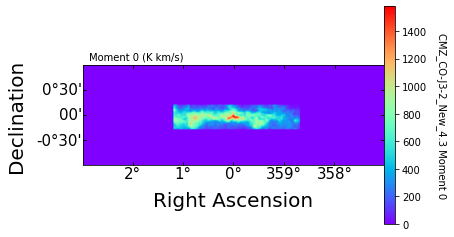

bp (2, 28287) (2, 295568)
OG noise =  0.07282070359110444 K
Reduced noise =  0.43 K
Manual Noise noise =  0.43 K


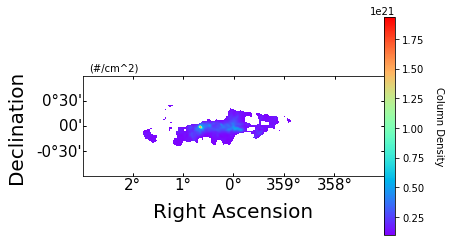

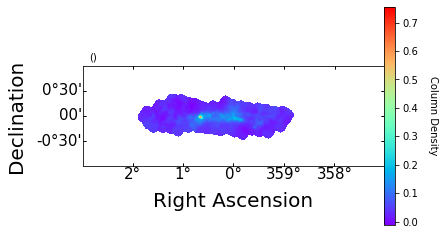

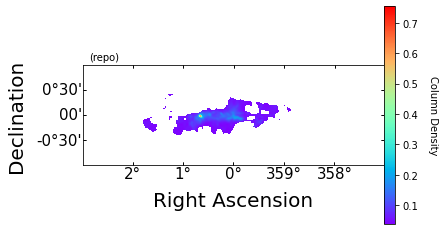

1.931503541697625e+21 1 / cm2 t


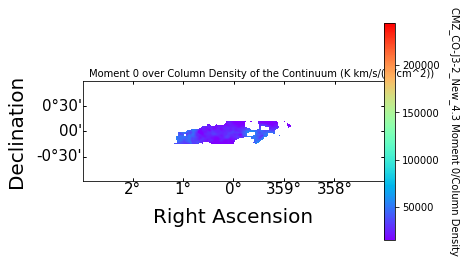

4456.6291179120735

7.396000000000046e-13 <class 'float'>
108.45422681126364 arcsec 108.45422681126364 arcsec
28.327249999999815 pix2
{'distance': <Quantity 0.008178 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 21.69084536 arcsec / pix>, 'arc_per_pix_x': <Quantity 21.69084536 arcsec / pix>, 'beam_major': <Quantity 108.45422681 arcsec>, 'beam_minor': <Quantity 108.45422681 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 0.00602523 deg>, 'velocity_scale': <Quantity 3.3 km / s>, 'vaxis': 0, 'wcsu': WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -249999.9999999952  
CRPIX : 0.0  0.0  -5.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.006025234822848  0.006025234822848  3300.0000000000005  
NAXIS : 995  331  152}
[[120, 195], [301, 712]] 

TypeError: unsupported operand type(s) for +: 'method' and 'float'

In [19]:


#CO 
#
#
#For the cube that has not been rotated
#
#
Num=5
Ram_Limiter=1#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New_4.3"
Name = "CMZ_CO 3-2_Abs_New_4.3"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level="All"
try:
    Names= list(np.load("Names_CMZ_New.npy"))
except:
    Names= list(np.load("Names_CMZ.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ_New",Names)

print(Name,Names)



#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New_4.3_70x360pc.fits"#"CMZ_CO_3_2_355_005_New_4.3.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New_4.3.fits'
pathCont = '4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'#'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[6:191,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()
Qpog = SpectralCube.read(pathog).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qpog.allow_huge_operations=True
Qpog = Qpog[6:191,:,:]#Get rid of the excess nan parts
Qog = Qpog.to(u.K)#Jy to Kelvin

scog = Qog.unmasked_copy()

scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn#[:,50:1300,50:1500]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#[:,50:1300,50:1500]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc







Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.01*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
print("bp",np.shape(bp),np.shape(bp2))
Continuum_Data[bp] = np.nan

cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan



Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0  ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K
m=.43
Non_nan=((scog.hdu.data[0,:,:]>0)  | (scog.hdu.data[0,:,:]<0 ))
mog = (np.nanstd(scog.hdu.data[0,:,:],where= Non_nan)) #Noise K
#m=.2
print("OG noise = ",mog,"K")

print("Reduced noise = ",m,"K")
print("Manual Noise noise = ",m,"K")

if(Abs_Level=="All"):
    pass
if(Abs_Level=="None"):
    datn[np.where(datn<0)]=np.nan
if(Abs_Level=="No Clusters"):
    IDs,Glon,Glat,HWHM  =    np.genfromtxt("CMZ_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("CMZ_Clusters_"+"Glon"+"",dtype=type("12h23.14s")),np.genfromtxt("CMZ_Clusters_"+"Glat"+"",dtype=type("12h23.14s")),np.genfromtxt("CMZ_Clusters_"+"HWHM"+"")

    datn=  Mask_Clusters_CMZ(HWHM,scWCS,scF.hdu.header,datn,Glon,Glat,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)



del scog
del Qog
del Qpog




Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","()",scCont.hdu.data,float(np.nanmin(scCont.hdu.data)),float(np.nanmax(scCont.hdu.data)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)
print(np.nanmax(cSD),'t')

Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs

#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit



vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances,V_err = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
plt.errorbar(Rads[0], Sigmas[0], yerr=V_err[0])
plt.show()
print(np.shape(Rads[0]),'rads')
print(np.shape(Sigmas[0]),"sigs")
print(np.shape(Rads[1]),'rads')
print(np.shape(Sigmas[1]),"sigs")
##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan

scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()

#Must use text because np load is broken
Abs_Level="All"
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


CMZ_CO 3-2_Abs_New_4.3 ['CMZ_HCOp 1-0_Abs_New', 'CMZ_HCN 1-0_Abs_New', 'CMZ_H13CN 1-0_Abs_New', 'CMZ_H13CO+ 1-0_Abs_New', 'CMZ_CO 3-2_Abs_New', 'CMZ_CO 3-2_Abs_New_4.3', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs']


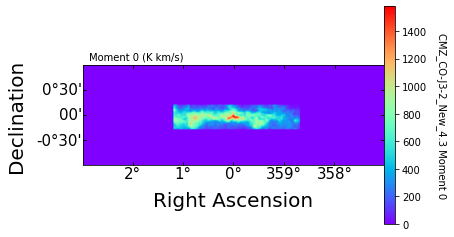

bp (2, 28287) (2, 295568)
OG noise =  0.07282070359110444 K
Reduced noise =  0.43 K
Manual Noise noise =  0.43 K
[-0.0185376  -0.01755708 -0.00504818 ... -0.00305275 -0.0111925
 -0.02026723]
[nan nan nan ... nan nan nan]


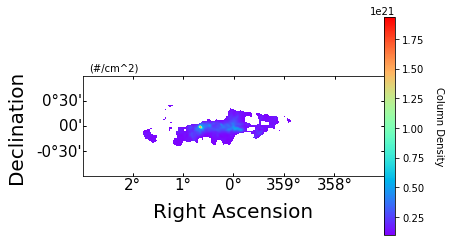

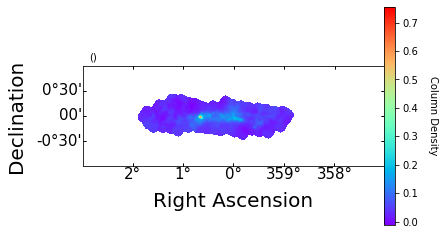

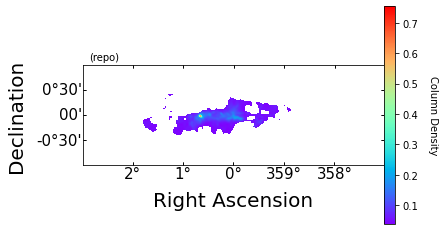

1.931503541697625e+21 1 / cm2 t


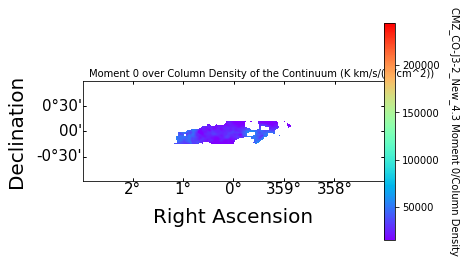

4456.6291179120735

7.396000000000046e-13 <class 'float'>
108.45422681126364 arcsec 108.45422681126364 arcsec
28.327249999999815 pix2
{'distance': <Quantity 0.008178 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 21.69084536 arcsec / pix>, 'arc_per_pix_x': <Quantity 21.69084536 arcsec / pix>, 'beam_major': <Quantity 108.45422681 arcsec>, 'beam_minor': <Quantity 108.45422681 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 0.00602523 deg>, 'velocity_scale': <Quantity 3.3 km / s>, 'vaxis': 0, 'wcsu': WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -249999.9999999952  
CRPIX : 0.0  0.0  -5.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.006025234822848  0.006025234822848  3300.0000000000005  
NAXIS : 995  331  152}
[[120, 195], [305, 712]] 

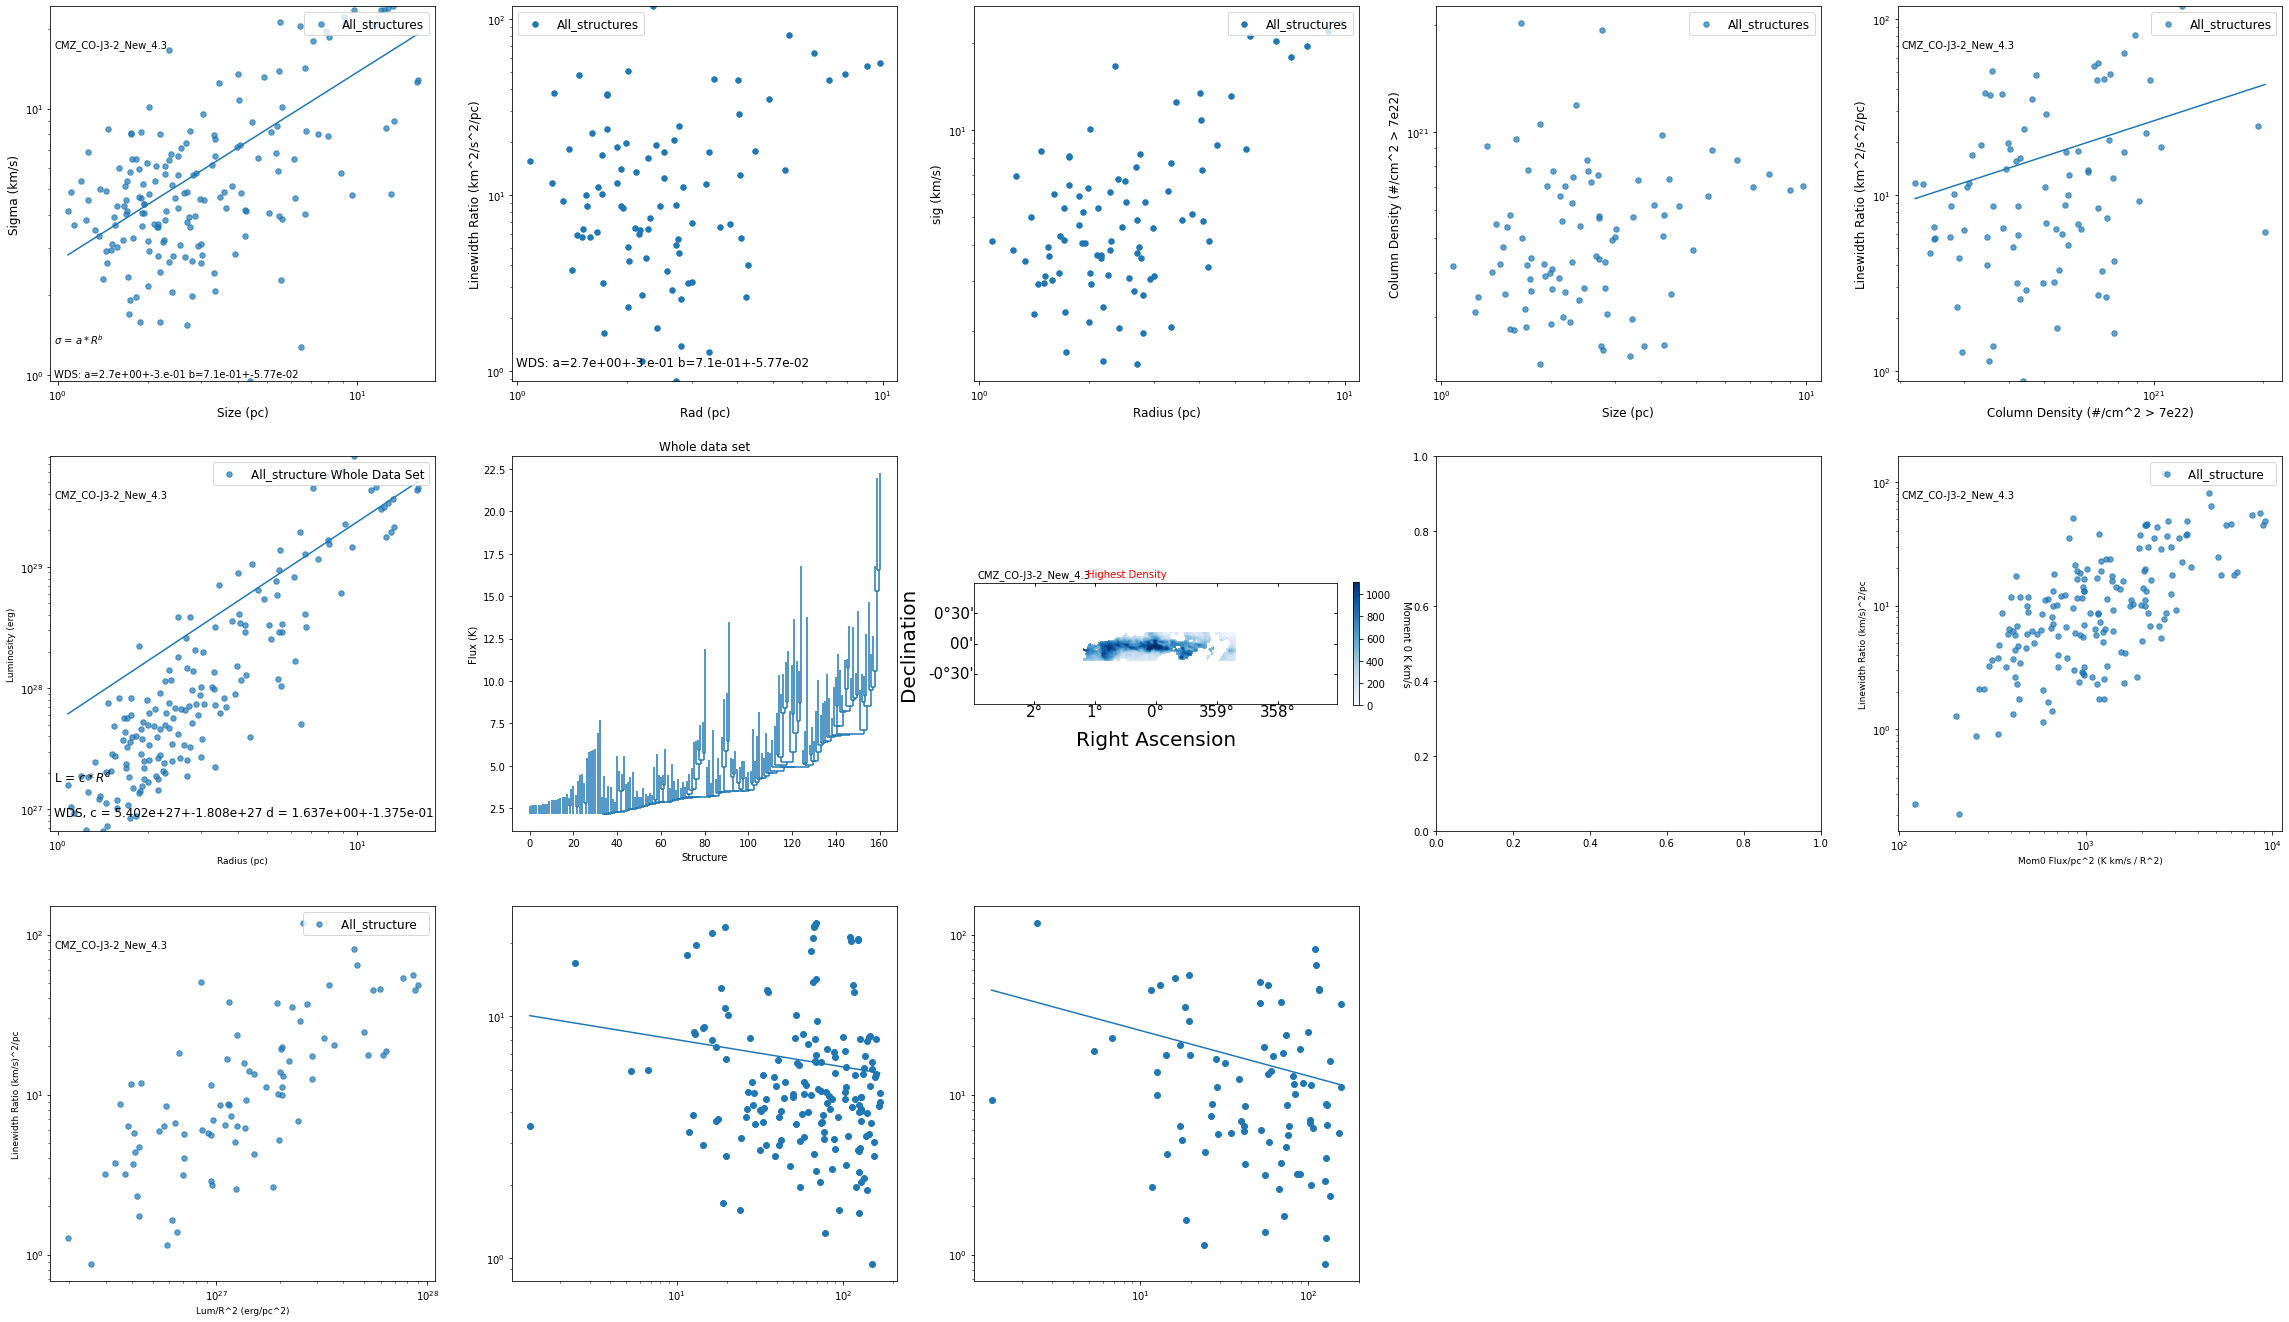

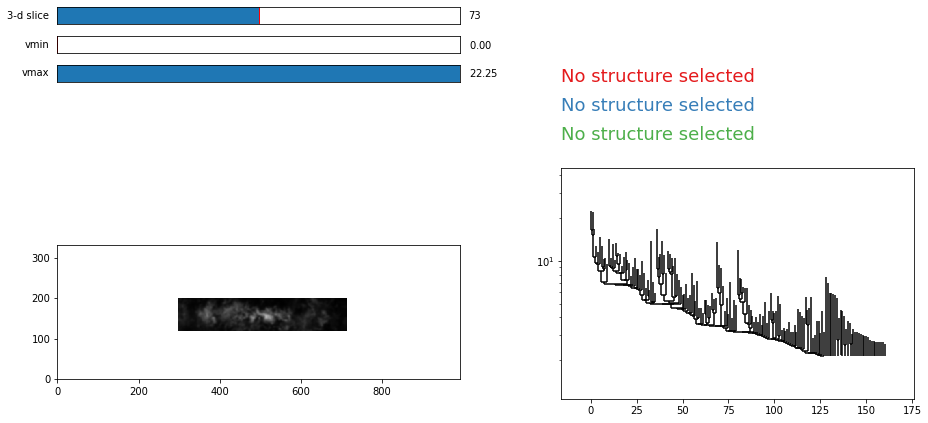

[262. 273.]


In [3]:


#CO 
#
#
#For the cube that has not been rotated
#
#
Num=5
Ram_Limiter=1#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New_4.3"
Name = "CMZ_CO 3-2_Abs_New_4.3"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level="None"
try:
    Names= list(np.load("Names_CMZ_New.npy"))
except:
    Names= list(np.load("Names_CMZ.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ_New",Names)

print(Name,Names)



#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New_4.3_70x360pc.fits"#"CMZ_CO_3_2_355_005_New_4.3.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New_4.3.fits'
pathCont = '4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'#'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[6:191,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()
Qpog = SpectralCube.read(pathog).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qpog.allow_huge_operations=True
Qpog = Qpog[6:191,:,:]#Get rid of the excess nan parts
Qog = Qpog.to(u.K)#Jy to Kelvin

scog = Qog.unmasked_copy()

scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn#[:,50:1300,50:1500]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#[:,50:1300,50:1500]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc







Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.01*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
print("bp",np.shape(bp),np.shape(bp2))
Continuum_Data[bp] = np.nan

cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan



Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0  ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K
m=.43
Non_nan=((scog.hdu.data[0,:,:]>0)  | (scog.hdu.data[0,:,:]<0 ))
mog = (np.nanstd(scog.hdu.data[0,:,:],where= Non_nan)) #Noise K
#m=.2
print("OG noise = ",mog,"K")

print("Reduced noise = ",m,"K")
print("Manual Noise noise = ",m,"K")

if(Abs_Level=="All"):
    pass
if(Abs_Level=="None"):
    kl=np.where(datn<0)
    print(datn[kl])
    datn[np.where(datn<0)]=np.nan
    print(datn[kl])
    
if(Abs_Level=="No Clusters"):
    IDs,Glon,Glat,HWHM  =    np.genfromtxt("CMZ_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("CMZ_Clusters_"+"Glon"+"",dtype=type("12h23.14s")),np.genfromtxt("CMZ_Clusters_"+"Glat"+"",dtype=type("12h23.14s")),np.genfromtxt("CMZ_Clusters_"+"HWHM"+"")

    datn=  Mask_Clusters_CMZ(HWHM,scWCS,scF.hdu.header,datn,Glon,Glat,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)



del scog
del Qog
del Qpog




Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","()",scCont.hdu.data,float(np.nanmin(scCont.hdu.data)),float(np.nanmax(scCont.hdu.data)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)
print(np.nanmax(cSD),'t')

Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs

#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit



vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
print(np.shape(Rads[0]),'rads')
print(np.shape(Sigmas[0]),"sigs")
print(np.shape(Rads[1]),'rads')
print(np.shape(Sigmas[1]),"sigs")
##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan

scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()


if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


CMZ_CO 3-2_Abs_New_4.3 ['CMZ_HCOp 1-0_Abs_New', 'CMZ_HCN 1-0_Abs_New', 'CMZ_H13CN 1-0_Abs_New', 'CMZ_H13CO+ 1-0_Abs_New', 'CMZ_CO 3-2_Abs_New', 'CMZ_CO 3-2_Abs_New_4.3', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs']


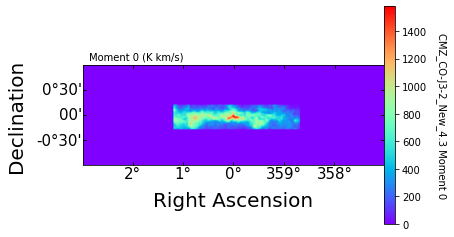

bp (2, 28287) (2, 295568)
OG noise =  0.07282070359110444 K
Reduced noise =  0.43 K
Manual Noise noise =  0.43 K


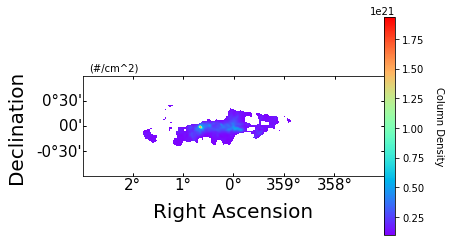

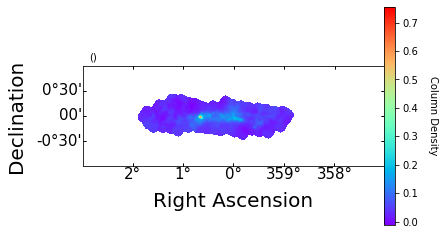

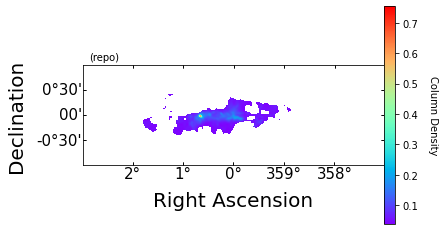

1.931503541697625e+21 1 / cm2 t


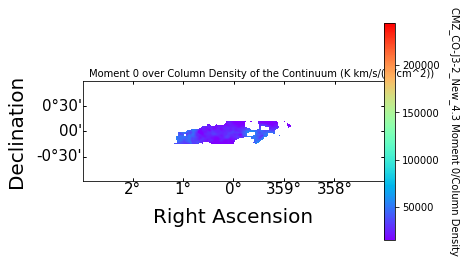

4456.6291179120735

7.396000000000046e-13 <class 'float'>
108.45422681126364 arcsec 108.45422681126364 arcsec
28.327249999999815 pix2
{'distance': <Quantity 0.008178 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 21.69084536 arcsec / pix>, 'arc_per_pix_x': <Quantity 21.69084536 arcsec / pix>, 'beam_major': <Quantity 108.45422681 arcsec>, 'beam_minor': <Quantity 108.45422681 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 0.00602523 deg>, 'velocity_scale': <Quantity 3.3 km / s>, 'vaxis': 0, 'wcsu': WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -249999.9999999952  
CRPIX : 0.0  0.0  -5.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.006025234822848  0.006025234822848  3300.0000000000005  
NAXIS : 995  331  152}
[[120, 195], [301, 712]] 

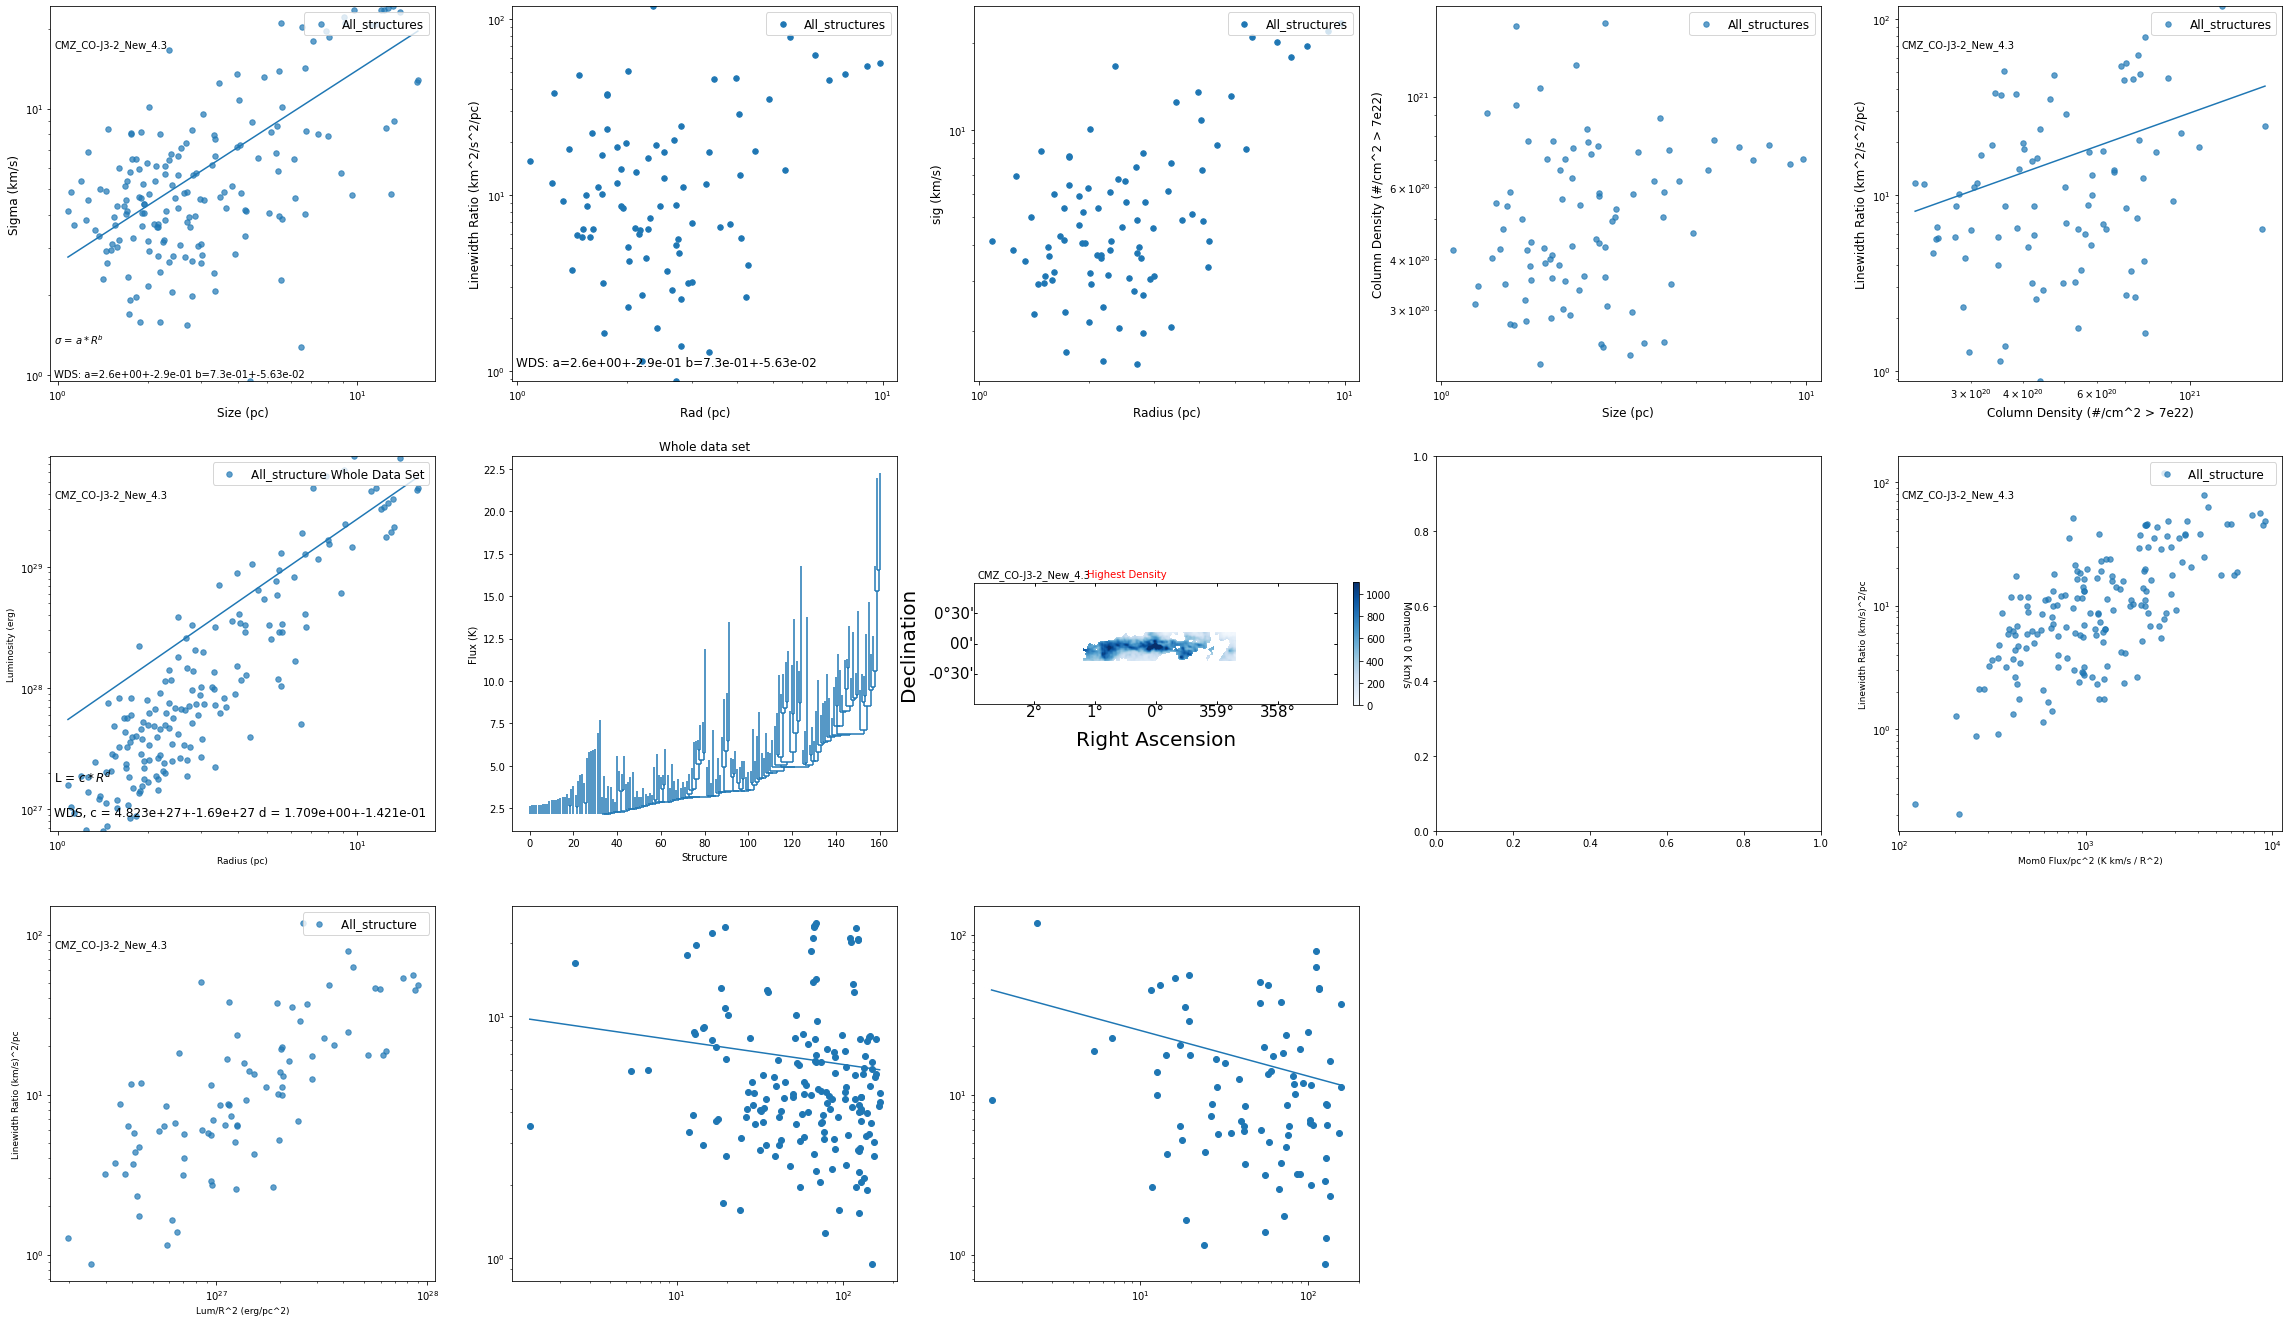

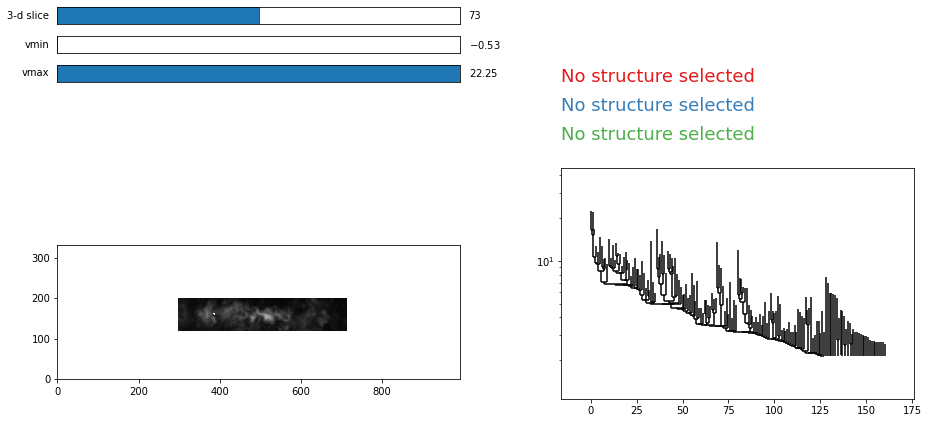

[262. 273.]


In [4]:


#CO 
#
#
#For the cube that has not been rotated
#
#
Num=5
Ram_Limiter=1#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New_4.3"
Name = "CMZ_CO 3-2_Abs_New_4.3"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New_4.3.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level="No Clusters"
try:
    Names= list(np.load("Names_CMZ_New.npy"))
except:
    Names= list(np.load("Names_CMZ.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ_New",Names)

print(Name,Names)



#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New_4.3_70x360pc.fits"#"CMZ_CO_3_2_355_005_New_4.3.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New_4.3.fits'
pathCont = '4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'#'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[6:191,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()
Qpog = SpectralCube.read(pathog).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qpog.allow_huge_operations=True
Qpog = Qpog[6:191,:,:]#Get rid of the excess nan parts
Qog = Qpog.to(u.K)#Jy to Kelvin

scog = Qog.unmasked_copy()

scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn#[:,50:1300,50:1500]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#[:,50:1300,50:1500]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc







Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.01*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
print("bp",np.shape(bp),np.shape(bp2))
Continuum_Data[bp] = np.nan

cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan



Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0  ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K
m=.43
Non_nan=((scog.hdu.data[0,:,:]>0)  | (scog.hdu.data[0,:,:]<0 ))
mog = (np.nanstd(scog.hdu.data[0,:,:],where= Non_nan)) #Noise K
#m=.2
print("OG noise = ",mog,"K")

print("Reduced noise = ",m,"K")
print("Manual Noise noise = ",m,"K")

if(Abs_Level=="All"):
    pass
if(Abs_Level=="None"):
    datn[np.where(datn<0)]=np.nan
if(Abs_Level=="No Clusters"):
    IDs,Glon,Glat,HWHM  =    np.genfromtxt("CMZ_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("CMZ_Clusters_"+"Glon"+"",dtype=type(3.1)),np.genfromtxt("CMZ_Clusters_"+"Glat"+"",dtype=type(3.1)),np.genfromtxt("CMZ_Clusters_"+"HWHM"+"")

    datn=  Mask_Clusters_CMZ(HWHM,scWCS,scF.hdu.header,datn,Glon,Glat,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)



del scog
del Qog
del Qpog




Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","()",scCont.hdu.data,float(np.nanmin(scCont.hdu.data)),float(np.nanmax(scCont.hdu.data)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)
print(np.nanmax(cSD),'t')

Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs

#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit



vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
print(np.shape(Rads[0]),'rads')
print(np.shape(Sigmas[0]),"sigs")
print(np.shape(Rads[1]),'rads')
print(np.shape(Sigmas[1]),"sigs")
##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan

scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()


if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])
